In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

The Taxi Problem
from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
by Tom Dietterich

Description:
There are four designated locations in the grid world indicated by R(ed), B(lue), G(reen), and Y(ellow). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drive to the passenger's location, pick up the passenger, drive to the passenger's destination (another one of the four specified locations), and then drop off the passenger. Once the passenger is dropped off, the episode ends.

Observations: 
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is the taxi), and 4 destination locations. 

Actions: 
There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger

Rewards: 
There is a reward of -1 for each action and an additional reward of +20 for delievering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.

Rendering:
- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters (R, G, B and Y): locations for passengers and destinations

actions:
- 0: south
- 1: north
- 2: east
- 3: west
- 4: pickup
- 5: dropoff

state space is represented by:
    (taxi_row, taxi_col, passenger_location, destination)

In [2]:
def get_q(env):
    num_actions = 6
    num_states = 5*5*5*4
    q = {state: np.random.rand(num_actions) for state in range(num_states)}

    for loc_id in range(len(env.locs)):
        loc = env.locs[loc_id]
        s = env.encode(loc[0], loc[1], loc_id, loc_id)
        q[s] = np.zeros(num_actions)
    
    return q

In [19]:
class Policy:
    def __init__(self, n):
        self.n = n
    
    def get_action(self, q):
        pass
    
class EpsilonGreedy(Policy):
    def __init__(self, epsilon = 0.1, n = 6):
        super().__init__(n)
        self.epsilon = epsilon
        
    def get_action(self, q, s):
        p = np.random.rand(1)
        if p < self.epsilon:
            a = np.random.randint(self.n)
        else:
            a = np.argmax(q[s])
        return a

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

class SoftmaxExploration(Policy):
    def __init__(self, temperature_factor = 1, n=6):
        super().__init__(n)
        self.temperature_factor = temperature_factor
        
    def get_action(self, q, s):
        return np.random.choice(self.n, 1, p=self.get_probability_action(q,s))[0]
    
    def get_probability_action(self, q, s):
        return softmax(q[s]/self.temperature_factor)

In [20]:
def test_policy(policy, q):
    s = env.reset()
    env.render()
    a = policy.get_action(q, s)
    done = False
    while not done:
        observation, reward, done, info = env.step(a) # take a random action
        s = observation
        a = policy.get_action(q, s)
        env.render()

Sarsa

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | :_:G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |

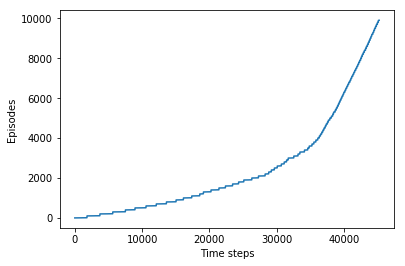

In [25]:
segment_len = 100
episode_by_segment = 10
    
env = gym.make('Taxi-v2')

def sarsa_update(env, policy, q, learning_rate, discount_rate):
    t=0
    s = env.reset()
    a = policy.get_action(q, s)
    done = False
    while not done:
        observation, reward, done, info = env.step(a)
        s_prime = observation
        a_prime = policy.get_action(q, s_prime)
        q[s][a] = q[s][a] + learning_rate * (reward + discount_rate * q[s_prime][a_prime] - q[s][a])
        s = s_prime
        a = a_prime
        t+=1
    return t

def qlearning_update(env, policy, q, learning_rate, discount_rate):
    t=0
    s = env.reset()
    done = False
    while not done:
        a = policy.get_action(q, s)
        observation, reward, done, info = env.step(a)
        s_prime = observation
        q[s][a] = q[s][a] + learning_rate * (reward + discount_rate * q[s_prime][np.argmax(q[s_prime])] - q[s][a])
        s = s_prime
        t+=1
    return t

def expected_sarsa_update(env, policy, q, learning_rate, discount_rate):
    t=0
    s = env.reset()
    done = False
    while not done:
        a = policy.get_action(q, s)
        observation, reward, done, info = env.step(a)
        s_prime = observation
        expectation = np.sum(policy.get_probability_action(q,s_prime)*q[s_prime])
        q[s][a] = q[s][a] + learning_rate * (reward + discount_rate * expectation - q[s][a])
        s = s_prime
        t+=1
    return t

episode_sequence = []
learning_rate = 0.5
discount_rate = 0.9
policy = SoftmaxExploration(temperature_factor=1)
q = get_q(env.unwrapped)

for segment in range(segment_len):
    for episode in range(episode_by_segment):
        t = expected_sarsa_update(env, policy, q, learning_rate, discount_rate)
        episode_sequence.extend([episode + segment*segment_len]*t )

test_policy(policy, q)

plt.plot(episode_sequence)
plt.xlabel("Time steps")
plt.ylabel("Episodes")
plt.show()